In [1]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

# Unzip to local runtime for speed
with zipfile.ZipFile('/content/drive/MyDrive/HackfestXDatathon2026ML/Training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Mounted at /content/drive


In [3]:
# ==========================================
# FINAL COLAB RESUME SCRIPT: SIM-TO-REAL
# ==========================================
!pip install -q segmentation-models-pytorch albumentations

import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from google.colab import drive

# 1. MOUNT & PATHS
drive.mount('/content/drive')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Update these to match your Drive folder structure
CHECKPOINT_PATH = '/content/drive/MyDrive/IBA_Hackathon_Final/deeplab_checkpoint_latest.pth'
DATA_DIR = './dataset/Offroad_Segmentation_Training_Dataset'
SAVE_DIR = '/content/drive/MyDrive/IBA_Hackathon_Final'
os.makedirs(SAVE_DIR, exist_ok=True)

# 2. CONFIG
BATCH_SIZE = 8 # T4 GPU can handle 8 with ResNet50
LR = 1e-4
EPOCHS = 20

# 3. DATASET & AUGMENTATIONS
value_map = {0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9}

def convert_mask(mask):
    arr = np.array(mask)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_val, class_id in value_map.items():
        new_arr[arr == raw_val] = class_id
    return new_arr

def get_train_aug():
    return A.Compose([
        A.Resize(544, 960),
        A.HorizontalFlip(p=0.5),
        # Sim-to-Real Jitter: Vital for generalizing to real-world data
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_aug():
    return A.Compose([
        A.Resize(544, 960),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

class OffroadDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.images = sorted([img for img in os.listdir(self.image_dir) if img.endswith('.png')])

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = np.array(Image.open(os.path.join(self.image_dir, img_name)).convert("RGB"))
        mask = convert_mask(np.array(Image.open(os.path.join(self.masks_dir, img_name))))
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']
        return image, mask

# Loaders - drop_last=True prevents the Batch Norm crash
train_ds = OffroadDataset(os.path.join(DATA_DIR, 'train'), transform=get_train_aug())
val_ds = OffroadDataset(os.path.join(DATA_DIR, 'val'), transform=get_val_aug())
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# 4. MODEL INITIALIZATION
print("⚙️ Initializing DeepLabV3+ ResNet-50...")
model = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=10).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scaler = torch.amp.GradScaler('cuda')

# 5. THE RESUME BLOCK
START_EPOCH = 1
best_iou = 0.0

if os.path.exists(CHECKPOINT_PATH):
    print(f"📥 Loading PC Checkpoint from {CHECKPOINT_PATH}...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    START_EPOCH = checkpoint['epoch'] + 1
    best_iou = checkpoint['best_iou']
    print(f"🔄 Resuming from Epoch {START_EPOCH}. Current Best IoU: {best_iou:.4f}")

# 6. TARGETED LOSS
# Weighted for Rocks(7) and Lush Bushes(2); Ignores missing Clutter/Logs
loss_weights = torch.tensor([0.0, 1.0, 50.0, 1.0, 2.0, 0.0, 0.0, 20.0, 1.0, 1.0]).to(DEVICE)
criterion_ce = nn.CrossEntropyLoss(weight=loss_weights)
criterion_dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

# 7. TRAINING LOOP
print(f"🚀 Starting Training on {DEVICE}...")
for epoch in range(START_EPOCH, EPOCHS + 1):
    model.train()
    train_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch} Train")

    for images, masks in progress:
        images, masks = images.to(DEVICE), masks.long().to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            logits = model(images)
            loss = criterion_ce(logits, masks) + criterion_dice(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    tp_tot, fp_tot, fn_tot, tn_tot = 0, 0, 0, 0
    with torch.no_grad():
        for imgs, msks in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            imgs, msks = imgs.to(DEVICE), msks.long().to(DEVICE)
            with torch.amp.autocast('cuda'):
                outputs = model(imgs)

            stats = smp.metrics.get_stats(outputs.argmax(dim=1), msks, mode='multiclass', num_classes=10)
            tp_tot += stats[0]; fp_tot += stats[1]; fn_tot += stats[2]; tn_tot += stats[3]

    val_iou = smp.metrics.iou_score(tp_tot, fp_tot, fn_tot, tn_tot, reduction="micro")
    print(f"⭐ Epoch {epoch} | Val IoU: {val_iou:.4f}")

    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), f"{SAVE_DIR}/deeplab_best.pth")
        print("💾 New Best Model Saved!")

    # Save checkpoint for potential resuming later
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_iou': best_iou,
    }, f"{SAVE_DIR}/deeplab_checkpoint_latest.pth")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚙️ Initializing DeepLabV3+ ResNet-50...


/tmp/ipython-input-2085106363.py:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


📥 Loading PC Checkpoint from /content/drive/MyDrive/IBA_Hackathon_Final/deeplab_checkpoint_latest.pth...
🔄 Resuming from Epoch 3. Current Best IoU: 0.6990
🚀 Starting Training on cuda...


Epoch 3 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 3 | Val IoU: 0.6766


Epoch 4 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 4 | Val IoU: 0.6884


Epoch 5 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 5 | Val IoU: 0.6882


Epoch 6 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 6 | Val IoU: 0.6970


Epoch 7 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 7 | Val IoU: 0.6984


Epoch 8 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 8 | Val IoU: 0.6841


Epoch 9 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 9 | Val IoU: 0.6994
💾 New Best Model Saved!


Epoch 10 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 10 | Val IoU: 0.7040
💾 New Best Model Saved!


Epoch 11 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 11 | Val IoU: 0.7067
💾 New Best Model Saved!


Epoch 12 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 12 | Val IoU: 0.7054


Epoch 13 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 13 | Val IoU: 0.7023


Epoch 14 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 14 | Val IoU: 0.7104
💾 New Best Model Saved!


Epoch 15 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 15 | Val IoU: 0.7173
💾 New Best Model Saved!


Epoch 16 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 16 | Val IoU: 0.7096


Epoch 17 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 17 | Val IoU: 0.7146


Epoch 18 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 18 | Val IoU: 0.7077


Epoch 19 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 19 | Val IoU: 0.7155


Epoch 20 Train:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/39 [00:00<?, ?it/s]

⭐ Epoch 20 | Val IoU: 0.7179
💾 New Best Model Saved!


In [4]:
# ==========================================
# BINARY OBSTACLE DETECTION (MICRO-MODEL)
# ==========================================
!pip install -q segmentation-models-pytorch albumentations

import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# 1. SETUP
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = './dataset/Offroad_Segmentation_Training_Dataset' # Update to your Colab path
BATCH_SIZE = 16 # ResNet-18 is light; we can use a larger batch for speed
EPOCHS = 10

# 2. BINARY REMAPPING LOGIC
# Class 1 (Obstacle): Trees, Bushes, Logs, Clutter, Rocks
# Class 0 (Safe): Landscape, Sky, Grass, Background
danger_vals = [100, 200, 500, 550, 700, 800]

def to_binary(mask):
    arr = np.array(mask)
    binary = np.zeros_like(arr, dtype=np.float32)
    for val in danger_vals:
        binary[arr == val] = 1.0
    return binary

class BinaryOffroadDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.images = sorted([i for i in os.listdir(self.image_dir) if i.endswith('.png')])

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = np.array(Image.open(os.path.join(self.image_dir, img_name)).convert("RGB"))
        mask = to_binary(Image.open(os.path.join(self.masks_dir, img_name)))

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']
        return image, mask.unsqueeze(0) # Binary needs (1, H, W)

# 3. FAST AUGMENTATIONS
aug = A.Compose([
    A.Resize(320, 640), # Lower res for maximum speed in this experiment
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

train_loader = DataLoader(BinaryOffroadDataset(os.path.join(DATA_DIR, 'train'), aug), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(BinaryOffroadDataset(os.path.join(DATA_DIR, 'val'), aug), batch_size=BATCH_SIZE)

# 4. MODEL & LOSS
# Binary UNet is excellent for finding small textures
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(DEVICE)
criterion = smp.losses.DiceLoss(mode='binary') # Dice is best for small object overlap
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. QUICK TRAINING
for epoch in range(1, EPOCHS + 1):
    model.train()
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

    # Simple Validation
    model.eval()
    val_iou = 0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
            pred = (torch.sigmoid(model(imgs)) > 0.5).float()
            intersection = (pred * msks).sum()
            union = (pred + msks).sum() - intersection
            val_iou += (intersection + 1e-6) / (union + 1e-6)
    print(f"⭐ Epoch {epoch} | Binary Obstacle IoU: {val_iou/len(val_loader):.4f}")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 1 | Binary Obstacle IoU: 0.4206


Epoch 2:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 2 | Binary Obstacle IoU: 0.4402


Epoch 3:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 3 | Binary Obstacle IoU: 0.5626


Epoch 4:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 4 | Binary Obstacle IoU: 0.5760


Epoch 5:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 5 | Binary Obstacle IoU: 0.5748


Epoch 6:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 6 | Binary Obstacle IoU: 0.5930


Epoch 7:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 7 | Binary Obstacle IoU: 0.6134


Epoch 8:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 8 | Binary Obstacle IoU: 0.6142


Epoch 9:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 9 | Binary Obstacle IoU: 0.5946


Epoch 10:   0%|          | 0/179 [00:00<?, ?it/s]

⭐ Epoch 10 | Binary Obstacle IoU: 0.6219


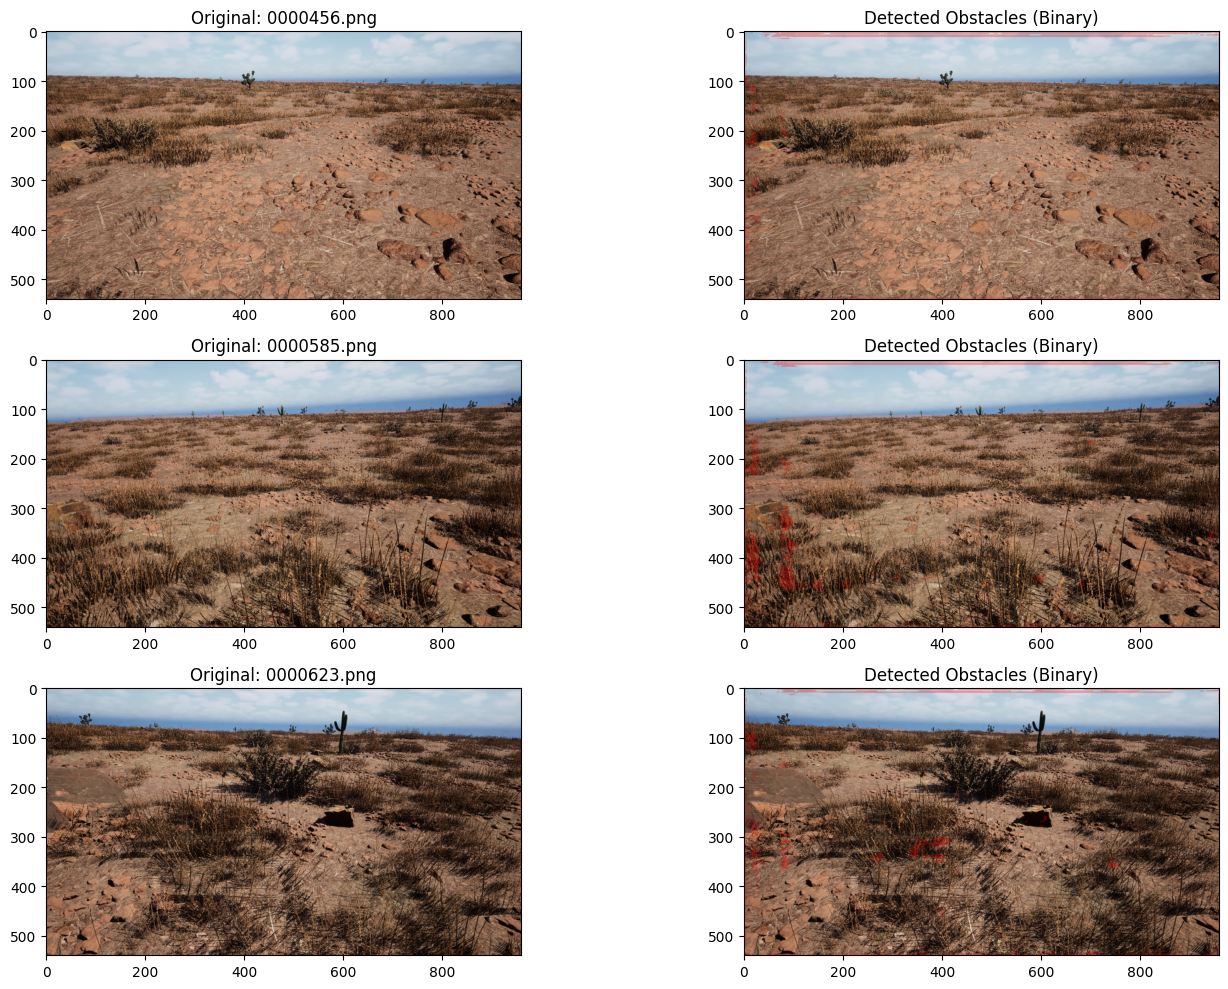

In [11]:
import torch
import numpy as np
import cv2
import os
from PIL import Image
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# 1. CONFIG
# Point this to your binary weights and test images
MODEL_PATH = 'binary_obstacle_model.pth'
TEST_IMG_DIR = './test/test_public_80/Color_Images'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. LOAD BINARY MODEL
# Using ResNet-18 as per your micro-experiment
model = smp.Unet(encoder_name="resnet18", encoder_weights=None, in_channels=3, classes=1).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# 3. TEST & VISUALIZE FUNCTION
def test_binary_visibility(image_path):
    # Prepare image
    raw_image = cv2.imread(image_path)
    raw_rgb = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    H, W = raw_rgb.shape[:2]

    # Preprocess (Resize to match your 320x640 experiment)
    img = cv2.resize(raw_rgb, (640, 320))
    img = img.transpose(2, 0, 1) / 255.0
    img_tensor = torch.tensor(img).float().unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        # Sigmoid to get probabilities
        output = torch.sigmoid(model(img_tensor))
        mask = (output > 0.5).float().cpu().numpy()[0][0]

    # Resize mask back to original image size
    mask_resized = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)

    # Create an overlay (Red for Obstacles)
    overlay = raw_rgb.copy()
    overlay[mask_resized == 1] = [255, 0, 0] # Red
    blended = cv2.addWeighted(raw_rgb, 0.7, overlay, 0.3, 0)

    return raw_rgb, blended

# 4. RUN ON 3 RANDOM SAMPLES
image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith('.png')][:3]
fig, axes = plt.subplots(len(image_files), 2, figsize=(15, 10))

for i, f in enumerate(image_files):
    orig, result = test_binary_visibility(os.path.join(TEST_IMG_DIR, f))
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title(f"Original: {f}")
    axes[i, 1].imshow(result)
    axes[i, 1].set_title("Detected Obstacles (Binary)")

plt.tight_layout()
plt.show()

In [6]:
# Save the weights to your Google Drive or local Colab disk
torch.save(model.state_dict(), 'binary_obstacle_model.pth')
print("✅ Binary weights saved as binary_obstacle_model.pth")

✅ Binary weights saved as binary_obstacle_model.pth


In [8]:
# Unzip to local runtime for speed
with zipfile.ZipFile('/content/drive/MyDrive/HackfestXDatathon2026ML/test_public_80.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/test')